In [1]:
%load_ext autoreload
%autoreload 2
%cd /home/xux/Desktop/Enzyme_design/Savi_design/Savinase-engineering

/home/xux/Desktop/Enzyme_design/Savi_design/Savinase-engineering


# Evaluate predictive models

# Model comparisons

## Activity model

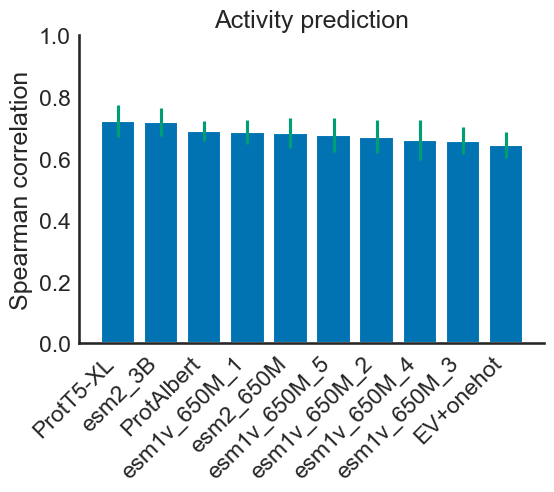

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from utils import plot_style_utils

methods = ['ProtT5-XL', 'esm2_3B', 'ProtAlbert', 'esm1v_650M_1', 'esm2_650M', 'esm1v_650M_5', 'esm1v_650M_2', 'esm1v_650M_4', 'esm1v_650M_3', 'EV+onehot']
spearman = [0.722, 0.718, 0.690, 0.686, 0.683, 0.678, 0.672, 0.661, 0.658, 0.645]
spearman_std = [0.052, 0.045, 0.032, 0.039, 0.048, 0.055, 0.053, 0.065, 0.044, 0.043]
plot_style_utils.set_pub_plot_context(context="talk")
fig, ax = plot_style_utils.simple_ax()
plot_style_utils.prettify_ax(ax)

ax.bar(methods, spearman, color=plot_style_utils.CAT_PALETTE[0])
ax.errorbar(methods, spearman, yerr=spearman_std, fmt='none', ecolor=plot_style_utils.CAT_PALETTE[2])
ax.set_title('Activity prediction')
ax.set_ylabel('Spearman correlation')
ax.set_ylim([0, 1.0])
ax.set_xticks(methods)
ax.set_xticklabels(methods, rotation=45, ha='right')
plot_style_utils.save_for_pub(fig=fig, path='figures/round3/act_pred_model_cmp')

## Stability model

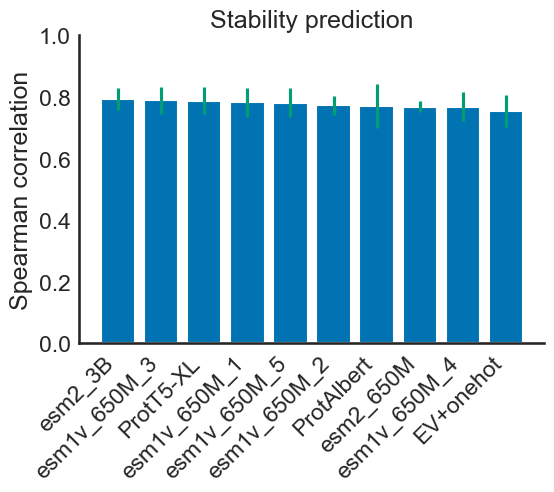

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from utils import plot_style_utils
from ipykernel import kernelapp as app

methods = ['esm2_3B', 'esm1v_650M_3', 'ProtT5-XL', 'esm1v_650M_1', 'esm1v_650M_5', 'esm1v_650M_2', 'ProtAlbert', 'esm2_650M', 'esm1v_650M_4', 'EV+onehot']
spearman = [0.794, 0.789, 0.788, 0.783, 0.782, 0.773, 0.770, 0.768, 0.768, 0.755]
spearman_std = [0.037, 0.044, 0.044, 0.048, 0.048, 0.030, 0.072, 0.018, 0.047, 0.053]

plot_style_utils.set_pub_plot_context(context="talk")
fig, ax = plot_style_utils.simple_ax()
plot_style_utils.prettify_ax(ax)

ax.bar(methods, spearman, color=plot_style_utils.CAT_PALETTE[0])
ax.errorbar(methods, spearman, yerr=spearman_std, fmt='none', ecolor=plot_style_utils.CAT_PALETTE[2])
ax.set_title('Stability prediction')
ax.set_ylabel('Spearman correlation')
ax.set_ylim([0, 1.0])
ax.set_xticks(methods)
ax.set_xticklabels(methods, rotation=45, ha='right')
plot_style_utils.save_for_pub(fig=fig, path='figures/round3/stab_pred_model_cmp')

# ProtT5 scatter plots

In [4]:
import os
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

def load_embeddings(config, backbone_model='ProtAlbert'):
    df_data = pd.read_csv(os.path.join(config.data_dir, 'data.csv'))
    embd_file = os.path.join(config.data_dir, backbone_model + '.npy')

    if os.path.exists(embd_file):
        prot_embd = np.load(embd_file)
    else:
        raise FileNotFoundError(f'Embedding file {embd_file} not found.')

    Xs = prot_embd
    Ys = df_data['log_fitness'].values
    indices = np.arange(len(Xs))

    Xs_train, Xs_test, ys_train, ys_test, indices_train, indices_test = train_test_split(Xs, Ys, indices, train_size=config.train_size)
    df_train = df_data.iloc[indices_train].copy()
    df_test = df_data.iloc[indices_test].copy()
    return Xs_train, Xs_test, df_train, df_test

In [5]:
from utils.utils import parse_config, set_random_seed
import pickle
from scipy.stats import spearmanr

def load_models(model_dir, head_model_type='svm'):
    pca_model = pickle.load(open(f'{model_dir}/pca_model.pkl', 'rb'))
    head_model = pickle.load(open(f'{model_dir}/head_model_{head_model_type}.pkl', 'rb'))
    return pca_model, head_model

def transform_pred(embeddings, pca_model, head_model):
    pca_embeddings = pca_model.transform(embeddings)
    pred = head_model.predict(pca_embeddings)
    return pred

# ! pip install scikit-learn==1.3.0

def pred_plm_fitness(data_config, model_config):
    set_random_seed(model_config.seed)
    Xs_train, Xs_test, df_train, df_test = load_embeddings(data_config, model_config.backbone_model)

    pca_model, head_model = load_models(model_config.model_dir, head_model_type=model_config.head_model)
    df_train['pred_fitness'] = transform_pred(Xs_train, pca_model, head_model)
    df_test['pred_fitness'] = transform_pred(Xs_test, pca_model, head_model)

    return df_train, df_test

In [6]:
config_path = 'third_round/config/predictor_plm_config.yaml'

config = parse_config(config_path)

In [12]:
import numpy as np
from utils import plot_style_utils
from scipy import stats

def plot_plm_scatter_plot(df_train, df_test, wt_score=-0.099922, wt_lab=0.0, prop='activity', model_id='plm1', ref='Savinase'):
    plot_style_utils.set_pub_plot_context(context="talk")
    fig, ax = plot_style_utils.simple_ax()
    plot_style_utils.prettify_ax(ax)

    ax.scatter(df_train.log_fitness, df_train.pred_fitness, alpha=0.4, label='Train', color=plot_style_utils.CAT_PALETTE[0])
    ax.scatter(df_test.log_fitness, df_test.pred_fitness, alpha=0.4, label='Test', color=plot_style_utils.CAT_PALETTE[1])
    ax.scatter([wt_lab], [wt_score], alpha=1.0, label=ref, color='black')

    train_fit = np.polyfit(df_train.log_fitness, df_train.pred_fitness, 1)
    x = np.sort(df_train.log_fitness)
    ax.plot(x, train_fit[0] * x + train_fit[1], linestyle=':', color=plot_style_utils.CAT_PALETTE[2])
    print(f"Train fit: {train_fit[0]:.3f}x + {train_fit[1]:.3f}")

    spearman = stats.spearmanr(df_test.log_fitness, df_test.pred_fitness)

    print(f"Test Spearman's rho: {spearman[0]:.3f}, p={spearman[1]:.3f}")
    ax.text(0.1, 0.9, "$\it{r}$"+f" = {spearman[0]:.2f}", transform=ax.transAxes)

    ax.set_xlabel(f'Experimental {prop}')
    ax.set_ylabel(f'Predicted {prop}')
    ax.legend(loc='lower right', frameon=False)
    prop = prop.replace(' ', '_')
    os.makedirs('figures/round3/pred_models', exist_ok=True)

    plot_style_utils.save_for_pub(fig=fig, path=f'figures/round3/pred_models/eval_{prop}_model_{model_id}')

## Activity

/home/xux/miniconda3/envs/prot-gen-env/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.3.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/xux/miniconda3/envs/prot-gen-env/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVR from version 1.3.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Train fit: 0.663x + -0.241
Test Spearman's rho: 0.806, p=0.000


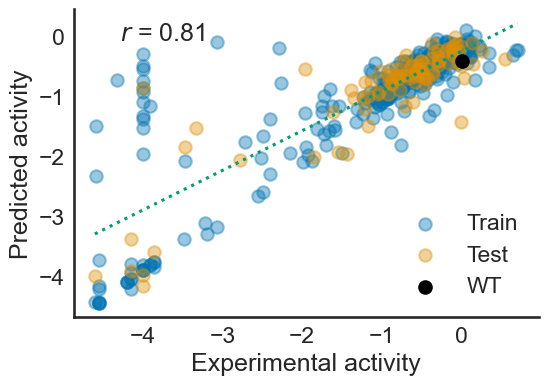

In [13]:
df_train, df_test = pred_plm_fitness(config.activity.data, config.activity.model1)

plot_plm_scatter_plot(df_train, df_test, wt_score=-0.401663, prop='activity', model_id='plm1', ref='WT')

## Stability

/home/xux/miniconda3/envs/prot-gen-env/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.3.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/xux/miniconda3/envs/prot-gen-env/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVR from version 1.3.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Train fit: 0.489x + -0.195
Test Spearman's rho: 0.821, p=0.000


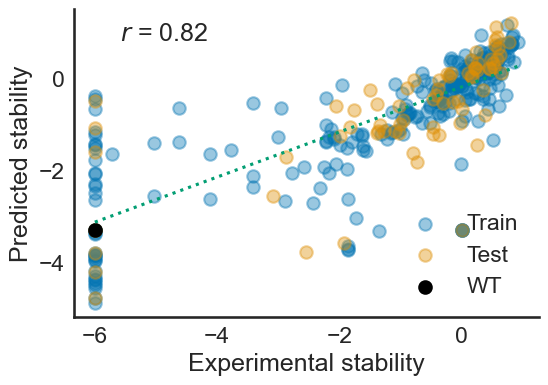

In [16]:
df_train, df_test = pred_plm_fitness(config.stability.data, config.stability.model3)
plot_plm_scatter_plot(df_train, df_test, wt_score=-3.295388, wt_lab=-6.0, prop='stability', model_id='plm3', ref='WT')